In [5]:
import numpy as np
import matplotlib.pyplot as plt

# The fast fourier transform 
## How to use it, and common pitfalls

Working in Cosmology, you will be using the fourier transform *a lot*. We all know the functional form of the fourier transform, 

$$ \tilde{f}(k) = \frac{1}{\sqrt{2\pi}}\int_{-\infty}^{\infty} dx \ f(x) e^{-ikx} $$

But although the things we study are continuous, when we're dealing with real experimental data or numerical simulations, we usually work with discrete **samples** of the continuous thing. So, you have to be able to do a numerical fourier transform for all of your discrete data! 

Luckily, you don't have to re-invent the wheel. Some clever programmers already came up with an algorithm for computing the discrete fourier transform, which numpy has helpfully wrapped in the function `fft`.  

In [11]:
from numpy.fft import fft

So let's see the fft in practice with a simple example. Let 

$$ f(x) = \sin \bigg( \frac{2\pi x}{L} \bigg)$$

Then, the fourier transform will be 

$$ \tilde{f}(k) = \frac{1}{2i \sqrt{2\pi} } \bigg[\delta \bigg(k + \frac{2\pi}{L} \bigg) - \delta \bigg(k - \frac{2\pi}{L} \bigg) \bigg]$$

so, we should expect a completely imaginary signal, with spikes at $k = 2\pi /L$ and $k = -2\pi / L$.

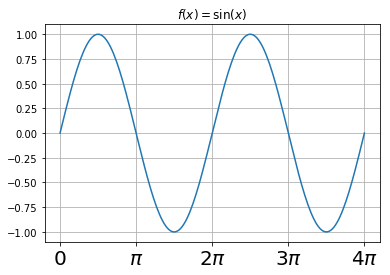

In [82]:
def function(x, L):
    return np.sin(2*np.pi*x/L)

#setting L = 2\pi means our sine wave has period of 2\pi
x = np.linspace(0,4*np.pi,200)
f = function(x, 2*np.pi)

fig, ax = plt.subplots()
ax.plot(x,f)
ax.set_xticks(np.arange(0,5*np.pi,np.pi))
ax.set_xticklabels([r"0",r"$\pi$",r"$2\pi$",r"$3\pi$",r"$4\pi$"],size = 20)
ax.set_title(r"$f(x) = \sin(x)$")
ax.grid()

Text(0.5, 1.0, 'Im$ [\\tilde{f}(k) ]$')

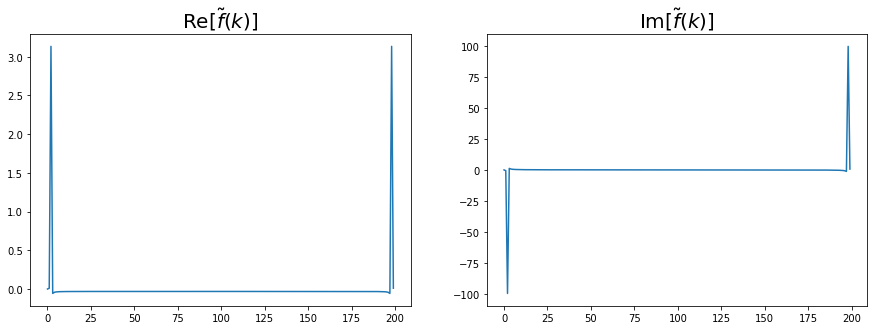

In [83]:
f_tilde = fft(f)

fig, (ax1,ax2) = plt.subplots(nrows =1,ncols = 2, figsize = (15,5))
ax1.plot(np.real(f_tilde))
ax1.set_title(r"Re$[ \tilde{f}(k) ]$",size =20)

ax2.plot(np.imag(f_tilde))
ax2.set_title(r"Im$ [\tilde{f}(k) ]$",size =20)

Ok... something strange is going. First thing that should seem weird is that the real part is not zero, as we would have expected. What's happening here?

## FFT pitfall #1: 

The FFT algorithm assumes a **periodic** signal. We're giving it what we think is a pure sine wave, but the FFT effectively tiles this signal we're giving it. So, after tiling, is it a pure sine wave? 

Text(0.5, 1.0, 'Zooming in around $4\\pi$')

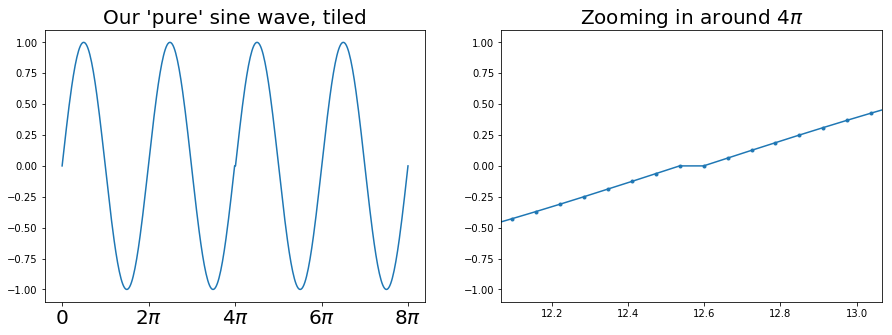

In [119]:
#let's reproduce what the fft "sees"
x_tiled = np.linspace(0,8*np.pi,400)
tiled = [list(f)*2][0]

fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
ax1.plot(x_tiled,tiled)
ax1.set_xticks(np.arange(0,9*np.pi,2*np.pi))
ax1.set_xticklabels([r"0",r"$2\pi$",r"$4\pi$",r"$6\pi$",r"$8\pi$"],size = 20)
ax1.set_title("Our 'pure' sine wave, tiled", size = 20)

ax2.plot(x_tiled,tiled, '.-')
ax2.set_xlim(4*np.pi-0.5, 4*np.pi+0.5)
ax2.set_title(r"Zooming in around $4\pi$", size = 20)

Aha! There's a little hump right where we tile the two sine waves. This is because if you look at how we defined our range of angles above, we did `np.linspace(0,4*np.pi,200)`. 

This means that `f[0] = 0` and `f[-1] = 0`, so when the fft algorithm applies periodic boundary conditions, there will be two zeros in series. That is, in fft's eyes, this is *not* a pure sine wave! 

Let's give fft a pure sine wave now.

Text(0.5, 1.0, 'Im$ [\\tilde{f}_{pure}(k) ]$')

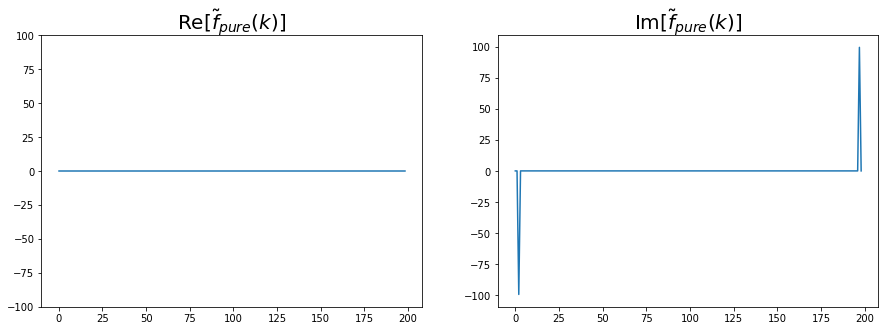

In [125]:
pure_sine = f[:-1] #popping out last element that would give repeated zeros
pure_sine_tilde = fft(pure_sine)

fig, (ax1,ax2) = plt.subplots(nrows =1,ncols = 2, figsize = (15,5))
ax1.plot(np.real(pure_sine_tilde))
ax1.set_title(r"Re$[ \tilde{f}_{pure}(k) ]$",size =20)
ax1.set_ylim(-100,100)

ax2.plot(np.imag(pure_sine_tilde))
ax2.set_title(r"Im$ [\tilde{f}_{pure}(k) ]$",size =20)

 Exactly as we expected! Wonderful! We've dodged the first FFT pitfall. 
 
But let's keep going, cause trust me, there are many more. How about the location of the peaks? We expect spikes at $k = 2\pi /L$ and $k = -2\pi / L$. Note I haven't plotted anything on the x-axis yet, so let's see how fft decides where to put the peaks. 

Let's look at this picture from the fantastic book *Numerical Recipes*. 

